In [174]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import mlxtend as mlx
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from mlxtend.frequent_patterns import fpgrowth
import matplotlib.pyplot as plt
from prefixspan import PrefixSpan
import seaborn as sns

### Importation des données

In [217]:
test = pd.read_csv("/Users/lemauffjulien/Documents/Titanic_project-master/titanic_data/raw_data/test.csv")
train = pd.read_csv("/Users/lemauffjulien/Documents/Titanic_project-master/titanic_data/raw_data/train.csv")

### Nettoyage et adaptation de la base de donnée

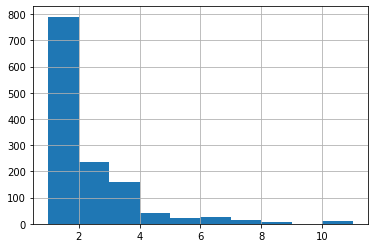

In [218]:
##### //-- CREATE DUMMY TO SEPARATE DATA LATER ON \\-- #####

# if Train_set = 1 the observation was in the train originally
train["Train_set"] = 1
test["Train_set"] = 0

# merge train and test
titanic = train.append(test, ignore_index=True, sort=False)

##### //-- CREATES DUMMY FOR SEX AND PCLASS VARIABLES \\-- #####

titanic = pd.concat([titanic, pd.get_dummies(titanic["Sex"])], axis=1)
titanic = pd.concat([titanic, pd.get_dummies(titanic["Pclass"])], axis=1)
titanic.rename(columns={1:'Pclass_1', 2:'Pclass_2', 3:'Pclass_3'}, inplace=True)

##### //-- EXTRACT TITLES FROM NAME VARIABLES \\-- #####

comma_split = titanic.Name.str.split(", ", n=1, expand=True)
point_split = comma_split.iloc[:, 1].str.split('.', n=1, expand=True)

titanic["Title"] = point_split.iloc[:, 0]
# We now have the title of each passenger separated from the variable Name
# There is in total 18 different title, I will narrow them down to make a generalized title class

def generalized_title(x):
    if x in ["Mr", 'Mrs', "Miss", "Master", "Dr"]:
        return(x)
    elif x in ["Don", "Lady", "Sir", "the Countess", "Dona", "Jonkheer"]:
        return("Nobility")
    elif x in ["Rev", "Major", "Col", "Capt"]:
        return("Officer")
    elif x == "Mme":
        return("Mrs")
    elif x in ["Ms", "Mlle"]:
        return("Miss")
    else:
        return("ERROR")

titanic["Title"] = titanic.Title.apply(lambda x: generalized_title(x))
# We now have narrowed down the 18 different title into only 7 generalized Title

# As we need the data in categorical form we will create dummy variables from Title
titanic = pd.concat([titanic, pd.get_dummies(titanic["Title"])], axis=1)

##### //-- CREATES FAMSIZE \\-- #####

# We create the variable Famsize as family size, the size of each family on board
titanic["Famsize"] = titanic['SibSp'] + titanic['Parch'] + 1
# It is important to add +1 because we have to count the person itself as member of the family

titanic.Famsize.value_counts()
titanic.Famsize.hist()
# Given the distribution of the variable we can create categorical variables based on group of family size

# I will therefore replace Famsize by it's categorical variable as :
# Famsize = solo if the person has no family on board and is travelling alone
# Famsize = small_family if the person has 2 or 3 members of his family on board (parents/children/siblings/spouses)
# Famsize = big_family if the person has strictly more than 4 members on his family on board

def Famsize_categorical(x):
    if x == 1:
        return("solo")
    if x in [2,3]:
        return ("small_family")
    elif x > 3:
        return("big_family")
    else:
        return("ERROR")

titanic["Famsize"] = titanic.Famsize.apply(lambda x: Famsize_categorical(x))

# As we need the data in categorical form we will create dummy variables from Famsize
titanic = pd.concat([titanic, pd.get_dummies(titanic["Famsize"])], axis=1)

##### //-- get Deck variable from Cabin \\-- #####

def get_deck(x):
    if pd.isnull(x) == True:
        return("Unknown")
    else:
        deck = re.sub('[^a-zA-Z]+', '', x)
        Deck = "".join(sorted(set(deck), key=deck.index))
        return(Deck.upper())
# This function check if the value is null, if it's true then the function return the null value
# If it's false then the function extract only unique characters from strings and return the upper case value

titanic["Deck"] = titanic["Cabin"].apply(lambda x: get_deck(x))

##### //-- Dropping variables \\-- #####

# As there is too many missing value for Cabin, 1014 missing values over 1309 it's not wise to keep the
# variable as it can create noises in the prediction. Therefore I have decided to remove the variable from the dataset
# There doesn't seem to have any valuable information in the variable Ticket so I will drop the variable off as well
titanic = titanic.drop(columns=["Cabin", 'Ticket'])

### Traitement des données manquantes 

In [219]:
titanic.isnull().sum()
# It seems that there is mostly missing values for the variables Embarked, Age and Fare

# //-- Let's try now to fill the missing values for each variables \\-- #

## Fill NaN in Embarked variable ##

titanic.Embarked.value_counts()

# The big majority of embarkation were from Southampton (S)
# Since there is only 2 missing values we can either decide to remove them or replace them by the most
# common embarkation port which is Southampton. I personally prefer the latter solution.

# let's replace the missing embarkation port by Southampton (S)
titanic.Embarked.fillna("S", inplace=True)

# Now that there is no more missing value we can create dummy variables for Embarked
titanic = pd.concat([titanic, pd.get_dummies(titanic["Embarked"])], axis=1)

## Fill NaN in Fare variable ##

titanic.Fare.fillna(titanic.Fare.median(), inplace=True)
# As there is only 1 missing value for Fare we can replace the missing value by it's median

### Traitement de la variable Age

In [220]:
# ==================== Fill NaN in Age variable  ==================== #

# Let's have a first statistical analysis
titanic.Age.describe()
# The mean and the median are close to each other with 29.9 and 28 respectively

# First solution: Replacing missing Age value by the median depending on the title
# Second solution: predicting missing Age with a random Forest
# Third solution; predicting missing Age with a SVM

titanic["Age_Randomforest"] = titanic.Age.copy() #Missing Age predicted by random forest
titanic["Age_SVM"] = titanic.Age.copy() #Missing Age predicted by SVM
titanic["Age_replace"] = titanic.Age.copy() #Missing Age replaced by median depending on title

# We will keep a variable Age for each solution and see later which one is better

# //-- Replacing Age depending on title \\-- #

Age_by_title = pd.DataFrame({'mean_age': titanic.groupby('Title').mean().loc[:, "Age"],
                             'median_age': titanic.groupby('Title').median().loc[:, "Age"],
                             'count': titanic.Title.value_counts(),
                             'age_missing': titanic.Age.isnull().groupby(titanic['Title']).sum()})
# We now have the mean and the median age for each title as well as the number of missing age for each title

# We will now replace the missing age by the median age depending on the title
for index, i in enumerate(titanic["Age_replace"]):
    if pd.isnull(i) == False:
        titanic.loc[index, "Age_replace"] = i
    else:
        i_title = titanic.loc[index, "Title"]
        titanic.loc[index, 'Age_replace'] = Age_by_title.loc[i_title, "median_age"]

### Random forest for Age

In [221]:
# we will now split the dataset into 2 datasets, the one with no empty age will be used as training data for the model
titanic_WithAge = titanic[pd.isnull(titanic['Age_Randomforest']) == False]
titanic_WithoutAge = titanic[pd.isnull(titanic['Age_Randomforest'])]

# We will use theses variables as independent variables to predict the Age
independent_variables = ['Pclass_1', 'Pclass_2', 'Pclass_3', 'female', 'male', 'C', 'Q', 'S',
                         'Dr', 'Master', 'Miss', 'Mr', 'Mrs', 'Nobility', 'Officer',
                         'big_family', 'small_family', 'solo', 'Parch', "SibSp", 'Fare']

rfModel_Age = RandomForestRegressor()

age_accuracies = cross_val_score(estimator=rfModel_Age,
                                 X=titanic_WithAge.loc[:, independent_variables],
                                 y=titanic_WithAge.loc[:, 'Age_Randomforest'],
                                 cv=10,
                                 n_jobs=2)

print("The MEAN CV score is", round(age_accuracies.mean(), ndigits=2))
print("The standard deviation is", round(age_accuracies.std(), ndigits=2))

# The MEAN CV score is 0.36
# The standard deviation is 0.08

# Fit the tunned model in the dataset

rfModel_Age.fit(titanic_WithAge.loc[:, independent_variables], titanic_WithAge.loc[:, 'Age_Randomforest'])

titanic_WithoutAge.loc[:, 'Age_Randomforest'] = rfModel_Age.predict(X = titanic_WithoutAge.loc[:, independent_variables]).astype(int)

titanic = titanic_WithAge.append(titanic_WithoutAge).sort_values(by=['PassengerId']).reset_index(drop=True)

The MEAN CV score is 0.36
The standard deviation is 0.1


/Users/lemauffjulien/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/lemauffjulien/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


### SVM for Age

/Users/lemauffjulien/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/lemauffjulien/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


The MEAN CV score is 0.39
The standard deviation is 0.06


/Users/lemauffjulien/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


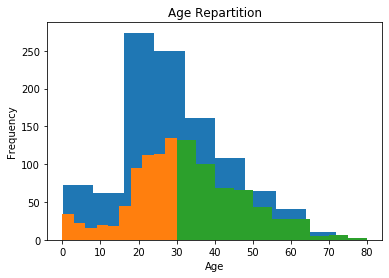

In [222]:
plt.hist(titanic.Age)
plt.hist(titanic.Age, range=(0, 30))
plt.hist(titanic.Age, range=(30, 80))
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Repartition')

# the distribution of the age looks almost like a normal distribution

titanic_WithAge_SVM = titanic[pd.isnull(titanic['Age']) == False]
titanic_WithoutAge_SVM = titanic[pd.isnull(titanic['Age'])]

SVM_reg = SVR(kernel="linear")

age_accuracies_SVM = cross_val_score(estimator=SVM_reg,
                                 X=titanic_WithAge_SVM.loc[:, independent_variables],
                                 y=titanic_WithAge_SVM.loc[:, 'Age_SVM'],
                                 cv=10,
                                 n_jobs=2)

print("The MEAN CV score is", round(age_accuracies_SVM.mean(), ndigits=2))
print("The standard deviation is", round(age_accuracies_SVM.std(), ndigits=2))

SVM_reg.fit(titanic_WithAge_SVM.loc[:, independent_variables], titanic_WithAge_SVM.loc[:, 'Age_SVM'])

titanic_WithoutAge_SVM.loc[:, 'Age_SVM'] = SVM_reg.predict(X = titanic_WithoutAge_SVM.loc[:, independent_variables]).astype(int)

titanic = titanic_WithAge_SVM.append(titanic_WithoutAge_SVM).sort_values(by=['PassengerId']).reset_index(drop=True)

### Groupe d'âge en utilisant Age_median

In [223]:
# Given the shape of the distribution we can separate the Age by group such as
# Age_group = 0_16 if the age is between 0 and 16 included
# Age_group = 17_24 if the age is between 17 and 24 included
# Age_group = 25_30 if the age is between 25 and 30 included
# Age_group = 31_40 if the age is between 31 and 40 included
# Age_group = over_40 if the age is strictly higher than 40

def Age_categorical(x):
    if x <= 16:
        return("0_16")
    elif x <= 30:
        return("17_30")
    elif x <= 40:
        return("31_40")
    else:
        return("over_40")

titanic["Age_group"] = titanic.Age_replace.apply(lambda x: Age_categorical(x))

### Séparation de la base de donnée pour retrouver les datasets train/test 

In [224]:
# I separate the titanic dataframe to their original train/test set
Clean_train = titanic.loc[titanic.Train_set == 1, :].reset_index(drop=True).drop("Train_set", axis=1)
Clean_test = titanic.loc[titanic.Train_set == 0, :].reset_index(drop=True).drop(["Train_set"], axis=1)

### Analyse statistique et descriptive

In [225]:
# ==================== DATA PROCESSING ==================== #

train = Clean_train

# //-- Pclass \\-- #

def Pclass_process(x):
    if x == 1:
        return('First_class')
    elif x == 2:
        return('Second_class')
    elif x == 3:
        return('Third_class')
    else:
        return("ERROR")

train.loc[:, "Pclass"] = train.Pclass.apply(lambda x: Pclass_process(x))

# //-- Survived \\-- #

def Survived_process(x):
    if x == 1.0:
        return("Survived")
    else:
        return("Died")

train.loc[:, "Survived"] = train.Survived.apply(lambda x: Survived_process(x))

# //-- Famsize \\-- #

def Famsize_process(x):
    if x == "small_family":
        return("small")
    elif x == "big_family":
        return("big")
    else:
        return(x)

train.loc[:, "Famsize"] = train.Famsize.apply(lambda x: Famsize_process(x))

# ==================== Statistical analysis ==================== #

# //-- Survival vs Pclass \\-- #

pd.crosstab(train['Pclass'],train['Survived']).plot.bar()
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Cross analysis between Survived an Pclass')
plt.legend(["Has died", "Has survived"])

# //-- Survival vs Sex \\-- #

pd.crosstab(train['Sex'],train['Survived']).plot.bar()
plt.xlabel('Sex')
plt.ylabel('Frequency')
plt.title('Cross analysis between Survived an Sex')
plt.legend(["Has died", "Has survived"])

# //-- Pclass vs Sex \\-- #

pd.crosstab(train['Pclass'],train['Sex']).plot.bar()
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Cross analysis between Pclass an Sex')

# //-- Title vs Survived \\-- #

pd.crosstab(train['Title'],train['Survived']).plot.bar()
plt.xlabel('Title')
plt.ylabel('Frequency')
plt.title('Cross analysis between Title an Sex')
plt.legend(["Has died", "Has survived"])

# # //-- Age vs Has Survived \\-- #
#
# pd.crosstab(train['Age_replace'], train.loc[train.Survived=="Survived", 'Survived']).plot.bar(color="green")
# plt.xlabel('Age')
# plt.ylabel('Frequency')
#
# # //-- Age vs Has Died \\-- #
#
# pd.crosstab(train['Age_replace'], train.loc[train.Survived=="Died", 'Survived']).plot.bar(color='red')
# plt.xlabel('Age')
# plt.ylabel('Frequency')

# //-- Famsize vs Survived \\-- #

pd.crosstab(train['Famsize'],train['Survived']).plot.bar()
plt.xlabel('Family size')
plt.ylabel('Frequency')
plt.title('Cross analysis between Family size an Survived')
plt.legend(["Has died", "Has survived"])


# //-- Boxplot Age by Survival \\-- #

sns.boxplot(x='Survived', y='Age_Randomforest', data=train)
ax = sns.stripplot(x='Survived', y='Age_Randomforest', data=train, color="black", jitter=0.2, size=2.5)
plt.title("Age Boxplot by Survival", loc="left")
plt.ylabel('Age')

sns.boxplot(x='Sex', y='Age_Randomforest', data=train)
ax = sns.stripplot(x='Sex', y='Age_Randomforest', data=train, color="black", jitter=0.2, size=2.5)
plt.title("Age Boxplot by Sex", loc="left")
plt.ylabel('Age')

# # //-- Boxplot Fare by Survival \\-- #
#
# sns.boxplot(x='Survived', y='Fare', data=train)
# ax = sns.stripplot(x='Survived', y='Fare', data=train, color="green", jitter=0.2, size=2.5)
# plt.title("Fare Boxplot by Survival", loc="left")
#
# # //-- Boxplot Fare by Pclass \\-- #
#
# sns.boxplot(x='Pclass', y='Fare', data=train)
# ax = sns.stripplot(x='Pclass', y='Fare', data=train, color="purple", jitter=0.2, size=2.5)
# plt.title("Fare Boxplot by Pclass", loc="left")

# //-- Boxplot Fare by Title \\-- #

sns.boxplot(x='Title', y='Age_Randomforest', data=train)
ax = sns.stripplot(x='Title', y='Age_Randomforest', data=train, color="red", jitter=0.2, size=2.5)
plt.title("Age Boxplot by Title", loc="left")
plt.ylabel('Age')

# //-- Stat descriptive \\-- #

column = ["Survived", "Pclass", "Sex", "Embarked", "Famsize", "Deck", "SibSp", "Parch"]

value_count = {}
for col in train.loc[:, column]:
    value_count.update({col: train.loc[:, col].value_counts()})

print(value_count)